In [10]:
import h5py 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats 
from extra_data import RunDirectory 

In [2]:
import xarray

def read_run_sync_trains(r, verbose=True):
    #clear_output(wait=False) 
    #sys.stderr.write(f'Processing run {r}...\n') 
    run = RunDirectory(path='/pnfs/xfel.eu/exfel/archive/XFEL/raw/SPB/202202/p003046/r%04d' % (r))  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
    ], require_all=True)
    if(verbose):
        sel.info()
    
    intensity_sase1_extra = sel['SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']
    intensity_preattenuator_sase1_extra = sel['SA1_XTD2_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']    
    motors_x_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_X.actualPosition.value']
    motors_y_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_Y.actualPosition.value']

    # Put the data in xarray
    motor_x = motors_x_extra.xarray()
    motor_y = motors_y_extra.xarray()
    xgm = intensity_sase1_extra.xarray()
    xgm2 = intensity_preattenuator_sase1_extra.xarray()
    
    directory = '/gpfs/exfel/u/scratch/SPB/202202/p003046/data' 
    agipd_frames_per_train = 202 # number of agipd frames per train
    with h5py.File(directory+'/r%04d_proc_radavg.h5' % (r)) as rad: 
        radavg = rad['entry_1']['radialavg'][:]
        trainIds = rad['entry_1']['trainId'][:]
        q = rad['entry_1']['q'][:]
    
    # Reshape the arrays from the radavg file to make them by train
    print(radavg.shape)
    radavg = radavg.reshape((-1,agipd_frames_per_train,radavg.shape[1]))
    trainIds = trainIds.reshape((-1,agipd_frames_per_train))
    # Ensure all the trains are the same length
    if (trainIds == trainIds[:,:1]).all() != True:
        raise ValueError        
    if(verbose):
        print("Reshaping of radavg successful:", (trainIds == trainIds[:,:1]).all())
    trainIds = trainIds[:,0]
    
    # Put radavg in an xarray
    radavg = xarray.DataArray(data=radavg, dims=('trainId', 'pulseNr', 'q'), 
                              coords={'trainId': trainIds, 'pulseNr': np.arange(agipd_frames_per_train), 'q': q})

    # Find trains which are common between radavg and the rest
    common_trains = np.intersect1d(intensity_sase1_extra.train_id_coordinates(), trainIds)
    if verbose:
        print("Found %d common train IDs between radavg and the rest" % len(common_trains))

    # Find the indices of the common trainIds and keep only those
    common_train_idx = np.searchsorted(intensity_sase1_extra.train_id_coordinates(),common_trains)
    motor_x = motor_x[common_train_idx]
    motor_y = motor_y[common_train_idx]
    xgm = xgm[common_train_idx]

    # Find the indices of the common trainIds for radavg    
    common_train_idx = np.searchsorted(radavg.coords['trainId'].data,common_trains)
    radavg = radavg[common_train_idx]
    
    train_ids_eq = (motor_x.coords['trainId'].data == radavg.coords['trainId'].data)
    if verbose:
        print("Train IDs all match:", train_ids_eq.all())
    
    return xgm, motor_x, motor_y, radavg, xgm2

In [3]:

def sync_pulses(xgm, radavg, xgm2):
    # Find out how many X-ray pulses per train

    npulses = np.sum(np.nanmean(xgm,axis=0) > 1.0)
    # For certain runs we actually receive more than 176 pulses, but the agipd will only record 176   
    npulses = min(npulses,176)
    agipd_frames_per_pulse = 176//npulses
    return xgm[:,:npulses], radavg[:,1:npulses*agipd_frames_per_pulse+1:agipd_frames_per_pulse,:], xgm2[:,:npulses]

In [6]:
def integrate_q_range(radavg, q_min = 0.73, q_max = 13, verbose=True):
    # q_min and q_max in 1/nm

    q = radavg.coords['q'].data
    q_min_idx = np.argmax(q > q_min)
    q_max_idx = np.argmax(q > q_max)
    
    if(verbose):
        print('Integrating between %g-%g 1/nm' % (q_min,q_max))   
    I = xarray.DataArray(data=np.nansum(radavg[:,:,q_min_idx:q_max_idx],axis=2), dims=('trainId', 'pulseNr'), coords={'trainId': radavg.coords['trainId'], 'pulseNr': radavg.coords['pulseNr']})
    return I

In [12]:
def combine_runs(runs):
    comb_xgm = None
    comb_motor_x = None
    comb_motor_y = None
    comb_radavg = None
    comb_xgm2 = None
    comb_I = None
    comb_R2 = None
    comb_slopes = None
    for run in runs:
        xgm, motor_x, motor_y, radavg, xgm2 = read_run_sync_trains(run, verbose=False)
        xgm, radavg, xgm2 = sync_pulses(xgm, radavg, xgm2)
        I = integrate_q_range(radavg, verbose=False)
        slopes, intercept, R2, _ = linear_fit_trains(xgm, I)
        #R2_by_n = log_linear_fits(xgm, I)
        #_, _, R2_2, _ = linear_fit_trains(xgm, I, n = 2)
        if comb_I is None:
            comb_I = I
        else:
            comb_I = xarray.concat((comb_I, I),'trainId')

        if comb_xgm is None:
            comb_xgm = xgm
        else:
            comb_xgm = xarray.concat((comb_xgm, xgm),'trainId')
            
        if comb_R2 is None:
            comb_R2 = R2
        else:
            comb_R2 = np.append(comb_R2, R2)
        if comb_slopes is None:
            comb_slopes = slopes
        else:
            comb_slopes = np.append(comb_slopes, slopes)
    return comb_R2, comb_slopes, comb_xgm, comb_I

In [8]:
def linear_fit_trains(xgm, I, n=1, do_corr = False):
    # Do a linear fit of the intensity I versus the xgm, n consecutive trains at a time
    # The default is to do one train at a time (n=1)
    slopes = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    intercept = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    R2 = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    RelError = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    Pearson_R = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    
    for i,idx in enumerate(np.arange(0,xgm.shape[0],n)):
        fit = stats.linregress(xgm.data[idx:idx+n].flatten(), I.data[idx:idx+n].flatten())
        if(do_corr):
            Pearson_R[i] = np.corrcoef(xgm.data[idx:idx+n].flatten(), I.data[idx:idx+n].flatten())[0,1]            
        slopes[i] = fit.slope
        intercept[i] = fit.intercept
        R2[i] = fit.rvalue**2
        fit_values = xgm.data[idx:idx+n].flatten()*fit.slope + fit.intercept
        RelError[i] = np.nanmean(np.abs((I.data[idx:idx+n].flatten() - fit_values)/fit_values))

    if(do_corr):
        return slopes, intercept, R2, RelError, Pearson_R
    else:
        return slopes, intercept, R2, RelError

In [13]:
comb_R2, comb_slopes, comb_xgm, comb_I = combine_runs([83,84,85,86])

(631250, 256)
(631654, 256)
(631452, 256)
(556510, 256)


In [14]:
comb_R2_lj, comb_slopes_lj, comb_xgm_lj, comb_I_lj = combine_runs([188,189,190,191,192])

(631452, 256)
(631250, 256)
(631452, 256)
(297546, 256)
(301990, 256)


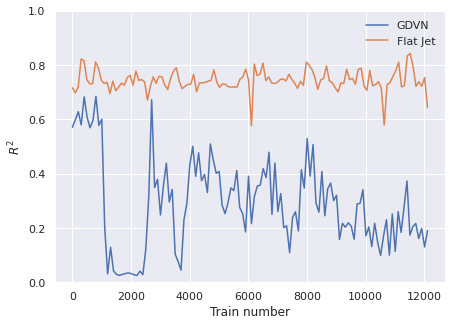

In [15]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set()

fig_handle = plt.figure(figsize=(7,5))
spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 1)
ax_i = fig_handle.add_subplot(spec_handle[0,0])
slopes, intercept, R2, _, Pearson_R = linear_fit_trains(comb_xgm, comb_I, n = 100, do_corr=True)
x = np.linspace(0,len(comb_xgm),num=len(R2))
plt.plot(x,R2,label='GDVN')
#plt.plot(x,Pearson_R**2,label='GDVN')
#ax_i.set_title('Correlation between scattered I and XGM for groups of 100 consecutive trains')
slopes, intercept, R2, _, Pearson_R = linear_fit_trains(comb_xgm_lj, comb_I_lj, n = 100, do_corr=True)
x = np.linspace(0,len(comb_xgm),num=len(R2))
plt.plot(x,R2,label='Flat Jet')
#plt.plot(x,Pearson_R**2,label='Flat Jet')
ax_i.set_ylim([0,1]);
ax_i.set_ylabel('$R^2$')
ax_i.set_xlabel('Train number')
ax_i.legend(frameon=False);
ax_i.spines['top'].set_visible(False)
ax_i.spines['right'].set_visible(False);
plt.savefig('correlation_I_xgm.pdf')
